# Stock Price Prediction
Using Hidden Markov Model, Kalman Filter, and Dynamic Bayesian Networks\
By: Peter

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define constants 5, 10, 20, 30, 50, 100, 200, 300, 
START_DATE = "2022-12-30"
# START_DATE = "2025-12-30"
END_DATE = "2025-03-31"
TICKER = "^GSPC"
WINDOW_SIZES = [500, 1000]

In [3]:
# Download S&P 500 data using yfinance
def download_data():
    df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)
    df = df[["Adj Close"]].dropna()
    df.reset_index(inplace=True)
    return df

# Compute Mean Absolute Percentage Error
def mape(actual, predicted):
    return np.abs((actual - predicted) / actual) * 100

# Base Class
class BaseModel:
    def fit(self, series):
        pass

    def predict(self):
        pass

# HMM
from hmmlearn.hmm import GaussianHMM

class HMMModel(BaseModel):
    def __init__(self, n_components=2):
        self.model = GaussianHMM(n_components=n_components)

    def fit(self, series):
        self.series = np.array(series).reshape(-1, 1)
        self.model.fit(self.series)

    def predict(self):
        logprob, hidden_states = self.model.decode(self.series)
        last_state = hidden_states[-1]
        return self.model.means_[last_state][0]

# Kalman Filter
from pykalman import KalmanFilter

class KalmanModel(BaseModel):
    def __init__(self):
        self.kf = KalmanFilter(transition_matrices=[1],
                               observation_matrices=[1],
                               initial_state_mean=0,
                               initial_state_covariance=1,
                               observation_covariance=1,
                               transition_covariance=0.0001)

    def fit(self, series):
        self.series = np.array(series)
        self.kf = self.kf.em(self.series, n_iter=5)
        self.filtered_state_means, _ = self.kf.filter(self.series)

    def predict(self):
        next_state = self.kf.transition_matrices[0] * self.filtered_state_means[-1]
        return next_state[0]

# Dynamic Bayesian Network
import pymc as pm

# class DBNModel(BaseModel):
#     def fit(self, series):
#         self.series = np.array(series)
#         y_t = self.series[1:]
#         y_tm1 = self.series[:-1]

#         with pm.Model() as self.model:
#             alpha = pm.Normal("alpha", mu=0, sigma=10)
#             beta = pm.Normal("beta", mu=0, sigma=1)
#             sigma = pm.HalfNormal("sigma", sigma=1)

#             mu = alpha + beta * y_tm1
#             y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_t)

#             self.trace = pm.sample(300, tune=200, cores=12, chains=2, progressbar=False, target_accept=0.9)

#     def predict(self):
#         last = self.series[-1]
#         alpha = self.trace.posterior["alpha"].mean().item()
#         beta = self.trace.posterior["beta"].mean().item()
#         return alpha + beta * last

class DBNModel(BaseModel):
    def fit(self, series):
        self.series = np.array(series)
        y_t = self.series[1:]
        y_tm1 = self.series[:-1]

        with pm.Model() as self.model:
            alpha = pm.Normal("alpha", mu=0, sigma=10)
            beta = pm.Normal("beta", mu=0, sigma=1)
            sigma = pm.HalfNormal("sigma", sigma=1)

            mu = alpha + beta * y_tm1
            y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_t)

            map_estimate = pm.find_MAP(progressbar=False)
            self.alpha = map_estimate["alpha"]
            self.beta = map_estimate["beta"]

    def predict(self):
        last = self.series[-1]
        return self.alpha + self.beta * last


# Evaluate model for a given window size
def evaluate_model(model_class, series, n):
    errors = []

    for i in tqdm(range(n, len(series) - 1)):
        window_data = series[i - n:i]
        actual = series[i]
        model = model_class()
        model.fit(window_data)
        pred = model.predict()
        if not np.isnan(pred):
            errors.append(mape(actual, pred))
    return np.mean(errors) if errors else np.nan


In [4]:
df = download_data()
prices = df["Adj Close"].values

[*********************100%***********************]  1 of 1 completed


In [5]:
results = {"n": WINDOW_SIZES}
models = {
    # "HMM": HMMModel,
    # "Kalman": KalmanModel,
    "DBN": DBNModel
}


Evaluating DBN...


  0%|          | 0/61 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains for 200 tune and 300 draw iterations (400 + 600 draws total) took 13 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
  2%|▏         | 1/61 [00:14<14:29, 14.48s/it]Initializing NUTS using jitter+adapt_diag...
Multiproc

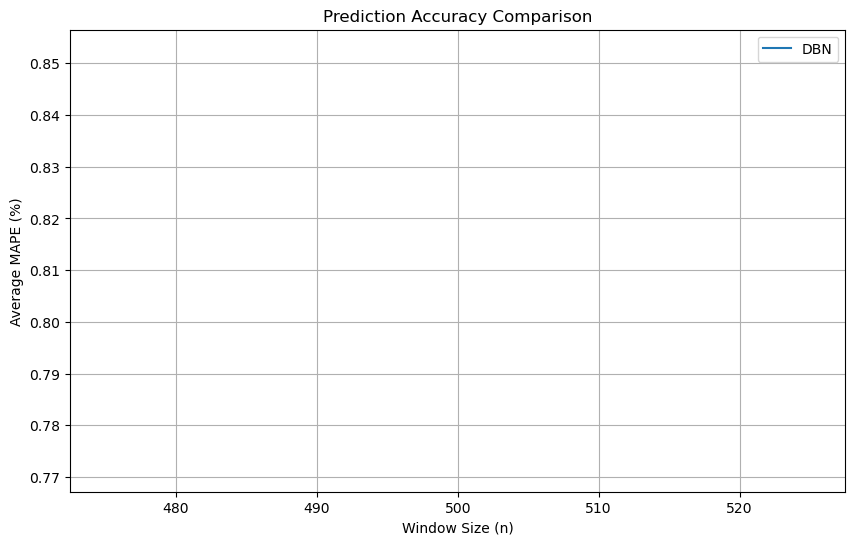

In [6]:
for name, ModelClass in models.items():
    avg_mapes = []
    print(f"\nEvaluating {name}...")
    for n in WINDOW_SIZES:
        avg_mape = evaluate_model(ModelClass, prices, n)
        avg_mapes.append(avg_mape)
    results[name] = avg_mapes

# Plotting
plt.figure(figsize=(10, 6))
for name in models:
    plt.plot(WINDOW_SIZES, results[name], label=name)
plt.xlabel("Window Size (n)")
plt.ylabel("Average MAPE (%)")
plt.title("Prediction Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
results

{'n': [500, 1000], 'DBN': [np.float64(0.811822703945733), nan]}